In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
from OptimizedDataGenerator import OptimizedDataGenerator

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-12-03 19:43:45.990288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:43:45.990347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:43:45.991771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:43:45.999284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 19:44:05.445951: W tensorflow/compiler/tf2

In [2]:
!pwd

/home/das214/MDMM


In [3]:
types = ['non_mdmm', 'mdmm']
fingerprints = ['636eb1c6',  '076ea794'] #'f07f9af3'] #

In [4]:
models = []
for i in range(len(types)):
    model = CreateModel((13,21,2), n_filters=5, pool_size=3)
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
        loss=custom_loss
    )
    models.append(model)

    base_dir = f'./trained_models_{types[i]}/model-{fingerprints[i]}-checkpoints'
    checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    training_cp_path = os.path.join(base_dir, 'training_log.csv')
    training_history = pd.read_csv(training_cp_path)

    print(f"Loading model from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
del model

2024-12-03 19:45:13.690965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 854 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-12-03 19:45:13.946948: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Loading model from ./trained_models_non_mdmm/model-636eb1c6-checkpoints/weights.99-t-23735.24-v-23528.96.hdf5
Loading model from ./trained_models_mdmm/model-076ea794-checkpoints/weights.77-t-10503.10-v-15125.95.hdf5


In [5]:
test_generators = []
p_tests = []
df_s = []
resX = []
resY = []
resA = []
resB  = []

for i in range(len(types)):
    tfrecords_dir_val = "/depot/cms/users/das214/tfrecords_2t_val_d8"
    print(tfrecords_dir_val)
    test_generator = OptimizedDataGenerator(
        load_from_tfrecords_dir = tfrecords_dir_val,
        quantize = True
    )
    test_generators.append(test_generator)
    p_test = models[i].predict(test_generator)
    p_tests.append(p_test)

    complete_truth = None
    for _, y in tqdm(test_generator):
            if complete_truth is None:
                complete_truth = y
            else:
                complete_truth = np.concatenate((complete_truth, y), axis=0)

    df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])
    
    # stores all true values in same matrix as xtrue, ytrue, etc.
    df['xtrue'] = complete_truth[:,0]
    df['ytrue'] = complete_truth[:,1]
    df['cotAtrue'] = complete_truth[:,2]
    df['cotBtrue'] = complete_truth[:,3]
    df['M11'] = minval+tf.math.maximum(df['M11'], 0)
    df['M22'] = minval+tf.math.maximum(df['M22'], 0)
    df['M33'] = minval+tf.math.maximum(df['M33'], 0)
    df['M44'] = minval+tf.math.maximum(df['M44'], 0)
    
    df['sigmax'] = abs(df['M11'])
    df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
    df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
    df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)
    
    # calculates residuals for x, y, cotA, cotB
    residuals = df['xtrue'] - df['x']
    residualsy = df['ytrue'] - df['y']
    residualsA = df['cotAtrue'] - df['cotA']
    residualsB = df['cotBtrue'] - df['cotB']

    df_s.append(df)
    resX.append(residuals)
    resY.append(residualsy)
    resA.append(residualsA)
    resB.append(residualsB)




/depot/cms/users/das214/tfrecords_2t_val_d8


 5/59 [=>............................] - ETA: 1s

2024-12-03 19:45:17.826696: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


59/59 [==============================] - 5s 70ms/step


100%|██████████| 59/59 [00:03<00:00, 15.30it/s]


/depot/cms/users/das214/tfrecords_2t_val_d8
59/59 [==============================] - 4s 69ms/step


100%|██████████| 59/59 [00:03<00:00, 16.27it/s]


# residuals (mean, stdv)

In [6]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(0.39304898818954825, 11.639176681637764)

In [7]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(0.21585143404081464, 2.94021712616086)

In [8]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(0.0301535464823246, 0.5318484306335449)

In [9]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(0.0006261840462684631, 0.07683601975440979)

# x residuals

type: non_mdmm
type: mdmm


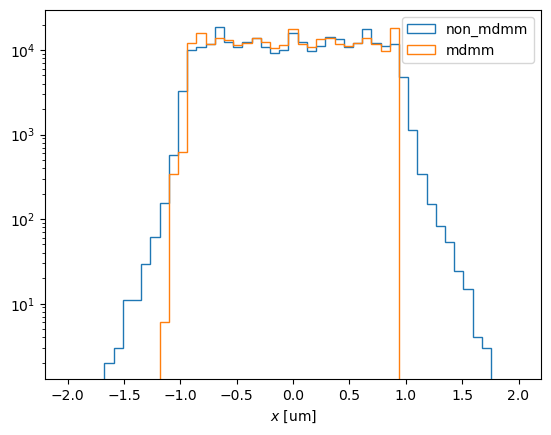

In [10]:
bins = np.linspace(-2, 2, 50)
for i, type in enumerate(types): 
    print(f'type: {types[i]}')
    plt.hist(p_tests[i][:,0],bins=bins, histtype='step', label = type)
plt.yscale('log')
plt.xlabel(r'$x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

type: non_mdmm
type: mdmm


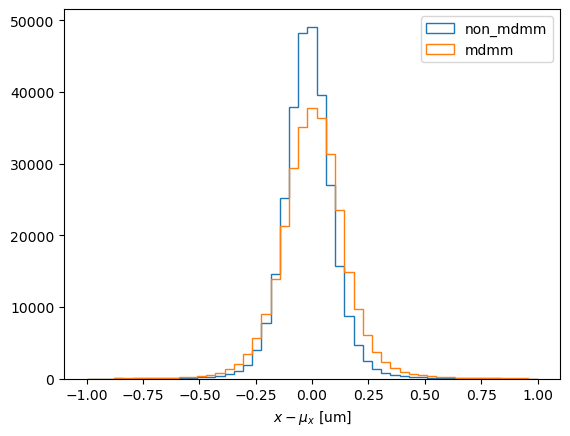

In [11]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    print(f'type: {types[i]}')
    plt.hist(resX[i],bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

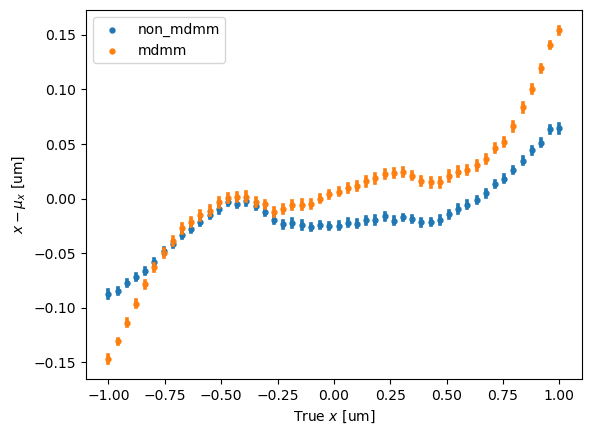

In [12]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['xtrue'], y=(df_s[i]['xtrue']-df_s[i]['x']),
                    x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend()
save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

type: non_mdmm
type: mdmm


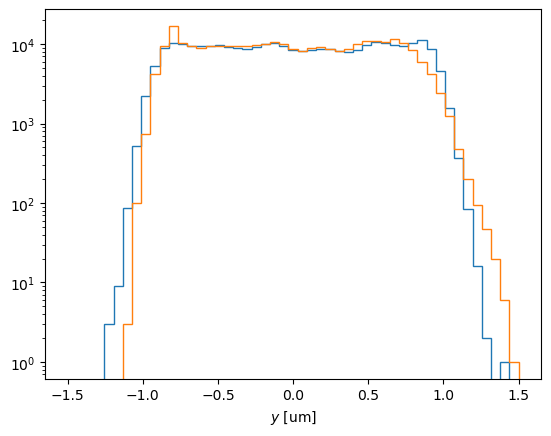

In [13]:
bins=np.linspace(-1.5,1.5,50)
for i, type in enumerate(types): 
    print(f'type: {types[i]}')
    plt.hist(p_tests[i][:,2],bins=bins, histtype='step', label = type)

plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

type: non_mdmm
type: mdmm


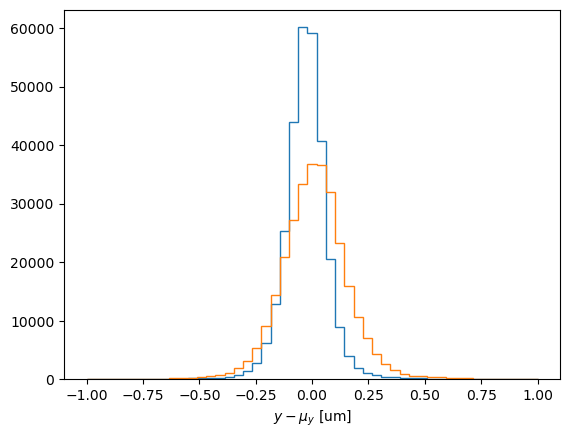

In [14]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    print(f'type: {types[i]}')
    plt.hist(resY[i],bins=bins, histtype='step', label = type)

#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

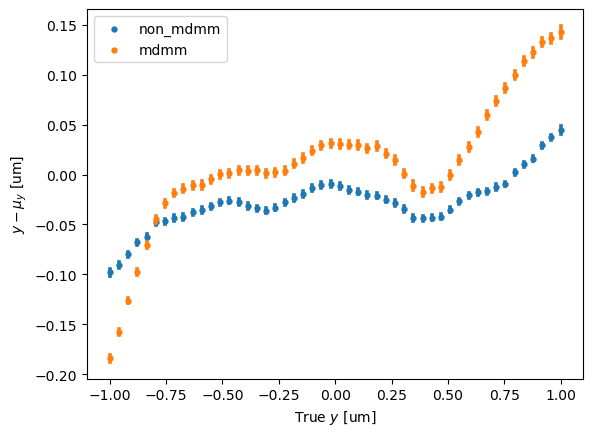

In [15]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['ytrue'], y=(df_s[i]['ytrue']-df_s[i]['y']), x_bins=np.linspace(-1,1,50),
                    fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')
plt.legend()

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

type: non_mdmm
type: mdmm


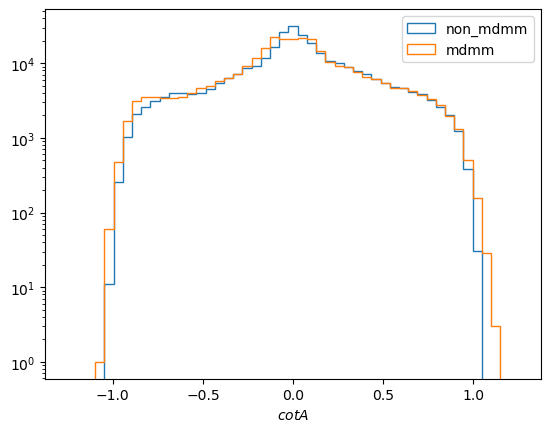

In [16]:
bins=np.linspace(-1.25,1.25,50)
for i, type in enumerate(types): 
    print(f'type: {types[i]}')
    plt.hist(p_tests[i][:,4],bins=bins, histtype='step', label = type)

plt.yscale('log')
plt.xlabel(r'$cotA$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

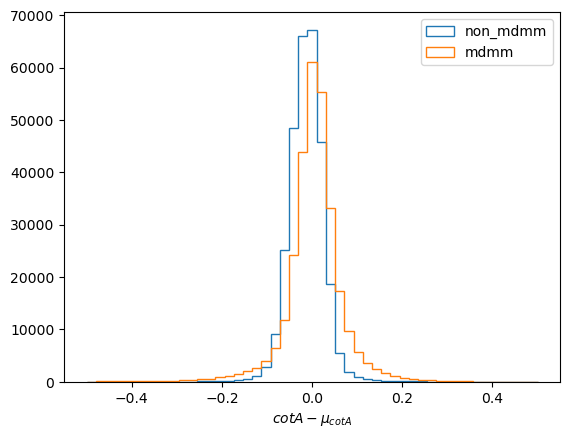

In [17]:
bins=np.linspace(-0.5,0.5,50)
for i, type in enumerate(types): 
    plt.hist(resA[i],bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

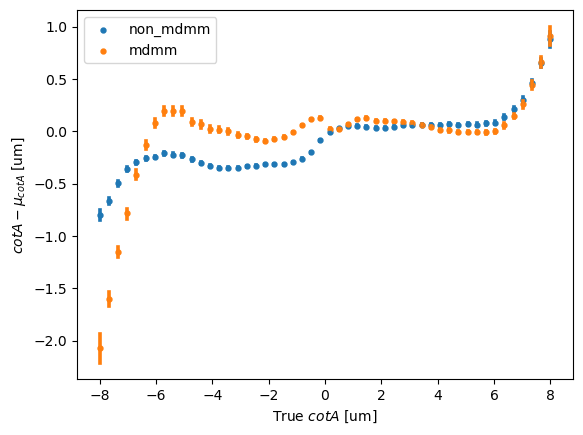

In [18]:

for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['cotAtrue']*8, y=(df_s[i]['cotAtrue']-df_s[i]['cotA'])*8,
                    x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

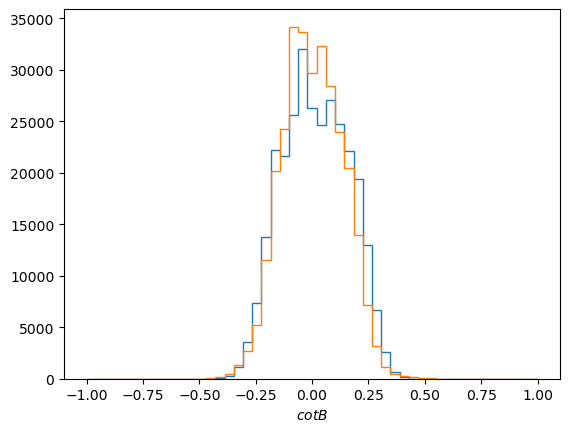

In [19]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
    plt.hist(p_tests[i][:,6]*0.5,bins=bins, histtype='step', label = type)
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

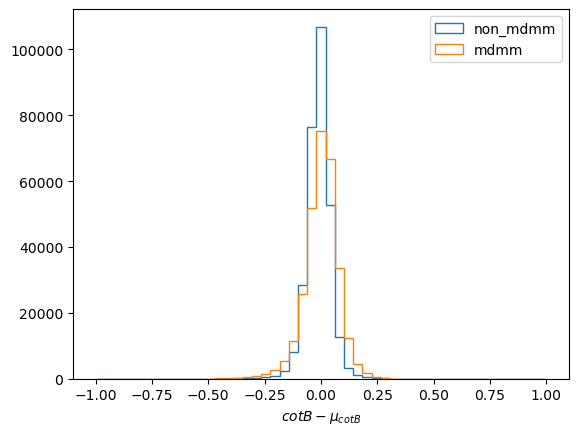

In [20]:
bins=np.linspace(-1,1,50)
for i, type in enumerate(types): 
     plt.hist(resB[i]*0.5,bins=bins, histtype='step', label = type)
    
#plt.yscale('Log')
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

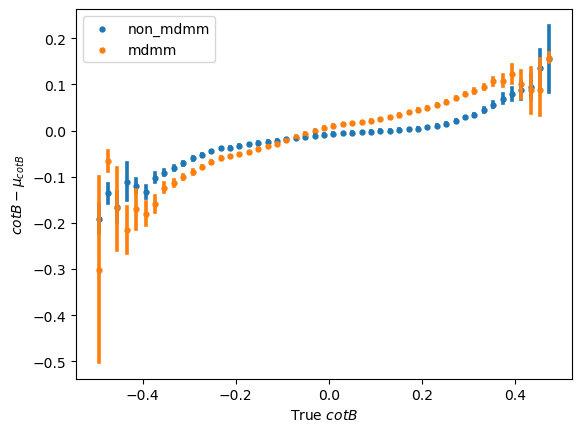

In [21]:
for i, type in enumerate(types): 
    x = sns.regplot(x=df_s[i]['cotBtrue']*0.5, y=(df_s[i]['cotBtrue']-df_s[i]['cotB'])*0.5,
                    x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.', label = type)
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')
plt.legend()

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [22]:
for i, type in enumerate(types): 
    df_s[i]['pullx'] = (df_s[i]['xtrue']-df_s[i]['x'])/df_s[i]['sigmax']
    df_s[i]['pully'] = (df_s[i]['ytrue']-df_s[i]['y'])/df_s[i]['sigmay']
    df_s[i]['pullcotA'] = (df_s[i]['cotAtrue']-df_s[i]['cotA'])/df_s[i]['sigmacotA']
    df_s[i]['pullcotB'] = (df_s[i]['cotBtrue']-df_s[i]['cotB'])/df_s[i]['sigmacotB']

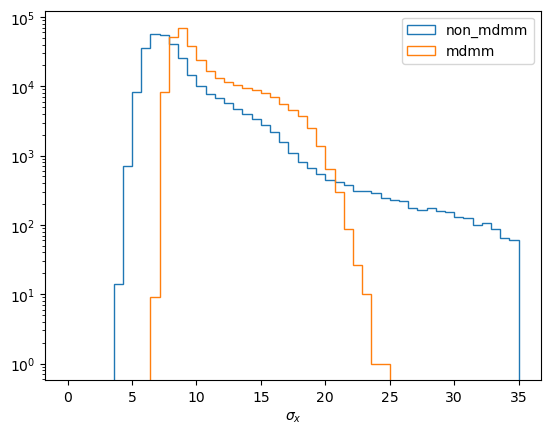

In [23]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmax'] * 75,bins=np.linspace(0,35,50), histtype='step', label = type)
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')
plt.legend()
plt.show()

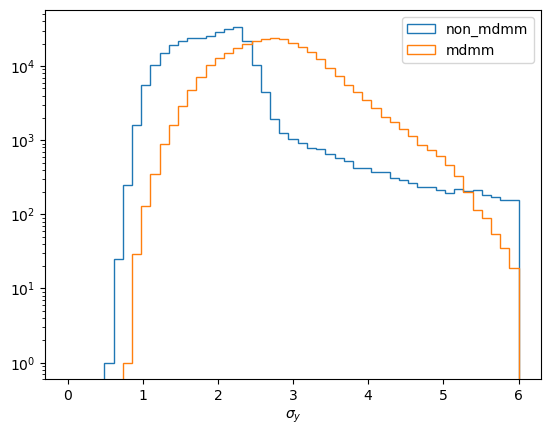

In [24]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmay']* 18.75,bins=np.linspace(0,6,50), histtype='step', label = type)
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')
plt.legend()
plt.show()

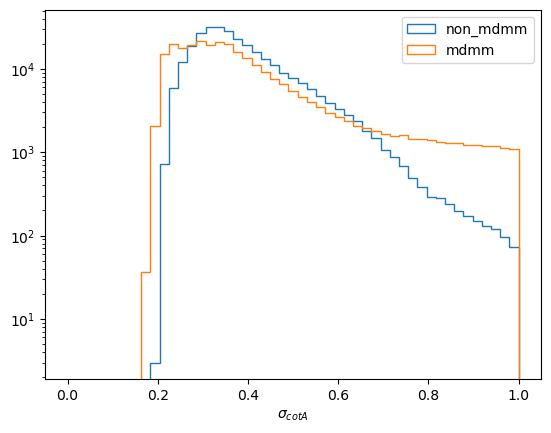

In [25]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmacotA'] * 8,bins=np.linspace(0,1.0,50), histtype='step', label = type)
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')
plt.legend()
plt.show()

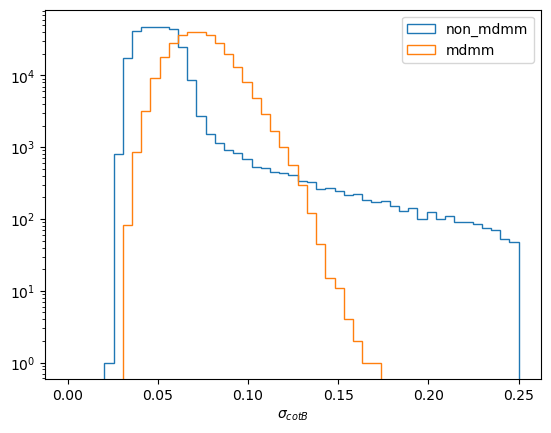

In [26]:
for i, type in enumerate(types): 
    plt.hist(df_s[i]['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50), histtype='step', label = type)
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')
plt.legend()
plt.show()

In [27]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, i, name, type):
    h = ax.hist(df_s[i][var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')
    ax.set_ylim(0.5,100000)


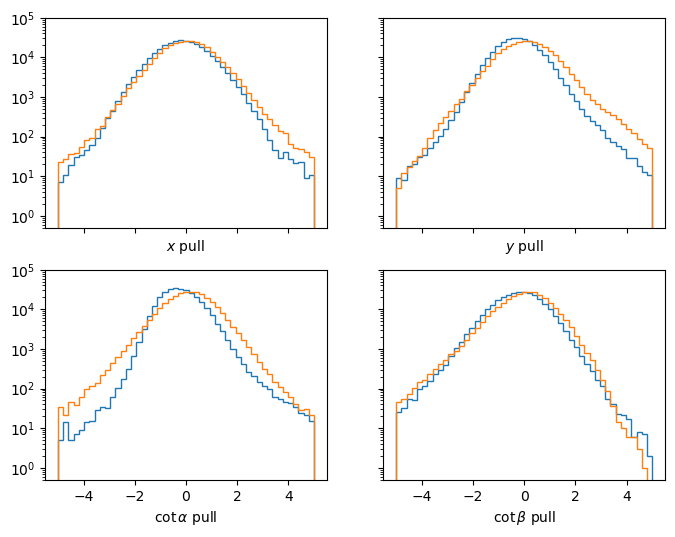

In [28]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
for i, type in enumerate(types): 
    pull_plot(axes[0][0],'pullx',i, r'$x$ pull', type)
    pull_plot(axes[0][1],'pully',i, r'$y$ pull', type)
    pull_plot(axes[1][0],'pullcotA',i, r'$\cot\alpha$ pull', type)
    pull_plot(axes[1][1],'pullcotB',i, r'$\cot\beta$ pull', type)

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [29]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,2000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,1000,"$\sigma$="+str(round(abs(pars[2]),2)))

Mean -0.008931044998097685
Sigma 0.9120664286481588
Mean 0.029025929269702763
Sigma 0.9039974541320699
Mean 0.08542142339800358
Sigma 0.8402670428425918
Mean 0.06358718560757073
Sigma 0.8612833002971115


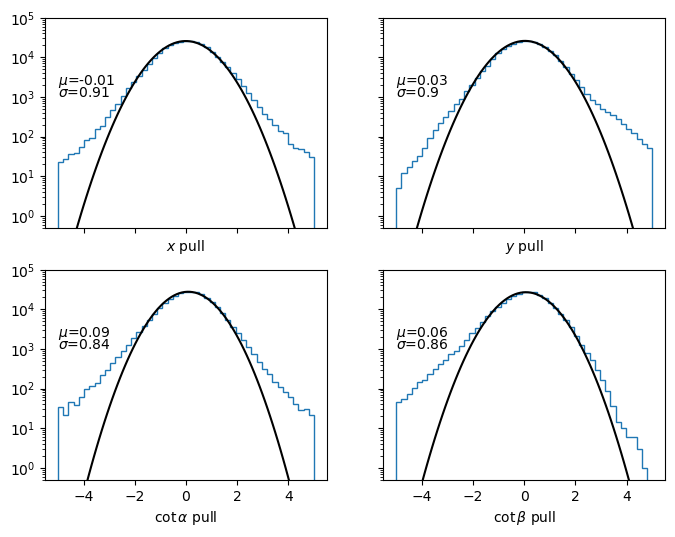

In [30]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [31]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0, hatch = '//', linestyle = '-', linewidth = 0.8):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    
    fill = ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2, hatch = hatch)
    fill_color = fill.get_facecolor()[0]
    x_points = np.linspace(xmin, xmax, nbins)

    fill.set_edgecolor(fill_color)
    
    ax.plot(x_points, upbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Upper Bound')
    ax.plot(x_points, downbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Lower Bound')

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0, hatch = '//', linestyle = '-', linewidth = 0.8):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    fill = ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2, hatch = hatch)

    fill_color = fill.get_facecolor()[0]
    x_points = np.linspace(xmin, xmax, nbins)

    fill.set_edgecolor(fill_color)
    
    ax.plot(x_points, upbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Upper Bound')
    ax.plot(x_points, downbar, color=fill_color, linestyle=linestyle, linewidth=linewidth, label='Lower Bound')

xtrue
ytrue


/tmp/ipykernel_832204/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_832204/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
xtrue
ytrue


/tmp/ipykernel_832204/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_832204/3159802458.py:39: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


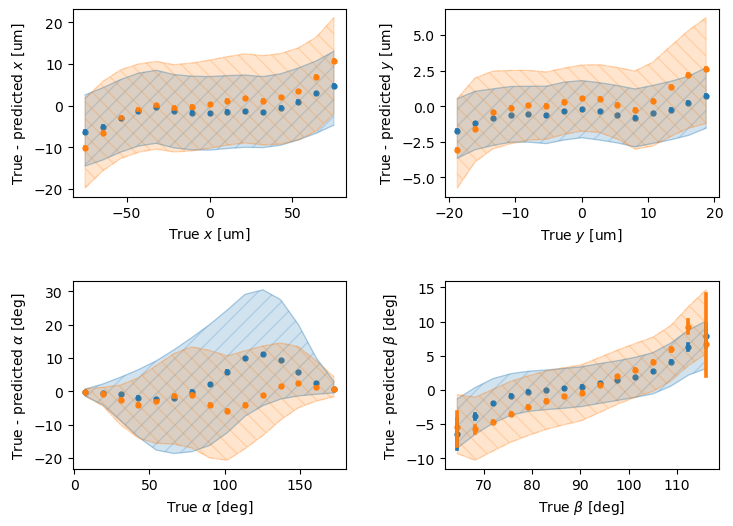

In [32]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)


geometry = ['non_mdmm (L1/L2 reg)', 'mdmm']
hatches = ['//', '\\\\']
linestyles = ['-', '-.']
linewidth = 2.0

labels = []
for i, type in enumerate(types): 
    label = f'{geometry[i]}'
    labels.append(label)
    residual_plot(axes[0][0],df_s[i],'xtrue','x',r'$x$ [um]', scaling=75.0, hatch = hatches[i], linestyle = linestyles[i])
    residual_plot(axes[0][1],df_s[i],'ytrue','y',r'$y$ [um]', scaling=18.75, hatch = hatches[i], linestyle = linestyles[i])
    residual_plot_deg(axes[1][0],df_s[i],'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0, hatch = hatches[i], linestyle = linestyles[i])
    residual_plot_deg(axes[1][1],df_s[i],'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5, hatch = hatches[i], linestyle = linestyles[i])

    

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)

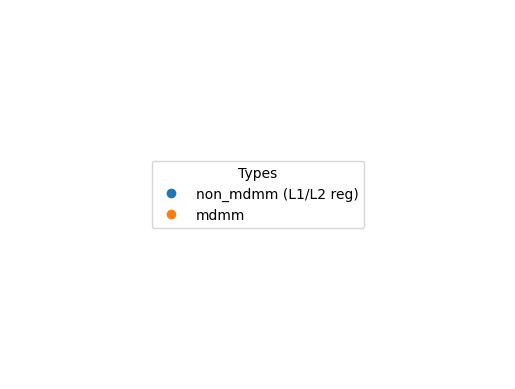

In [33]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
for color, label in zip(default_colors, labels):
    ax.plot([], [], color=color, label=label, marker='o', linestyle='None') 
legend = ax.legend(loc='center', frameon=True, title="Types")
ax.axis('off') 
plt.show()

In [34]:
epsilon = 1e-3
zero_count = 0
total_count = 0
for layer in models[0].layers:
    if layer.weights:
        weights = tf.convert_to_tensor(layer.get_weights()[0])
        abs_weights = tf.abs(weights)
        zero_count += tf.reduce_sum(tf.cast(tf.less_equal(abs_weights, epsilon), tf.int32))
        total_count += tf.size(weights)

print(f"Model sparsity after training (non_mdmm): {zero_count / total_count:.3f}")

Model sparsity after training (non_mdmm): 0.006


In [35]:
epsilon = 1e-3
zero_count = 0
total_count = 0
for layer in models[1].layers:
    if layer.weights:
        weights = tf.convert_to_tensor(layer.get_weights()[0])
        abs_weights = tf.abs(weights)
        zero_count += tf.reduce_sum(tf.cast(tf.less_equal(abs_weights, epsilon), tf.int32))
        total_count += tf.size(weights)

print(f"Model sparsity after training (non_mdmm): {zero_count / total_count:.3f}")

Model sparsity after training (non_mdmm): 0.668


Weights and Biases Comparison for q_separable_conv2d (Model 0) and q_separable_conv2d_1 (Model 1):
  q_separable_conv2d/depthwise_kernel:0 - Model 0: Mean=-0.67, StdDev=0.30, Norm=0.67
  q_separable_conv2d/depthwise_kernel:0 - Model 1: Mean=0.57, StdDev=0.31, Norm=0.57
  q_separable_conv2d/pointwise_kernel:0 - Model 0: Mean=-0.33, StdDev=0.72, Norm=0.71
  q_separable_conv2d/pointwise_kernel:0 - Model 1: Mean=-0.39, StdDev=0.71, Norm=0.72
  q_separable_conv2d/bias:0 - Model 0: Mean=0.00, StdDev=0.32, Norm=0.26
  q_separable_conv2d/bias:0 - Model 1: Mean=-0.03, StdDev=0.26, Norm=0.22


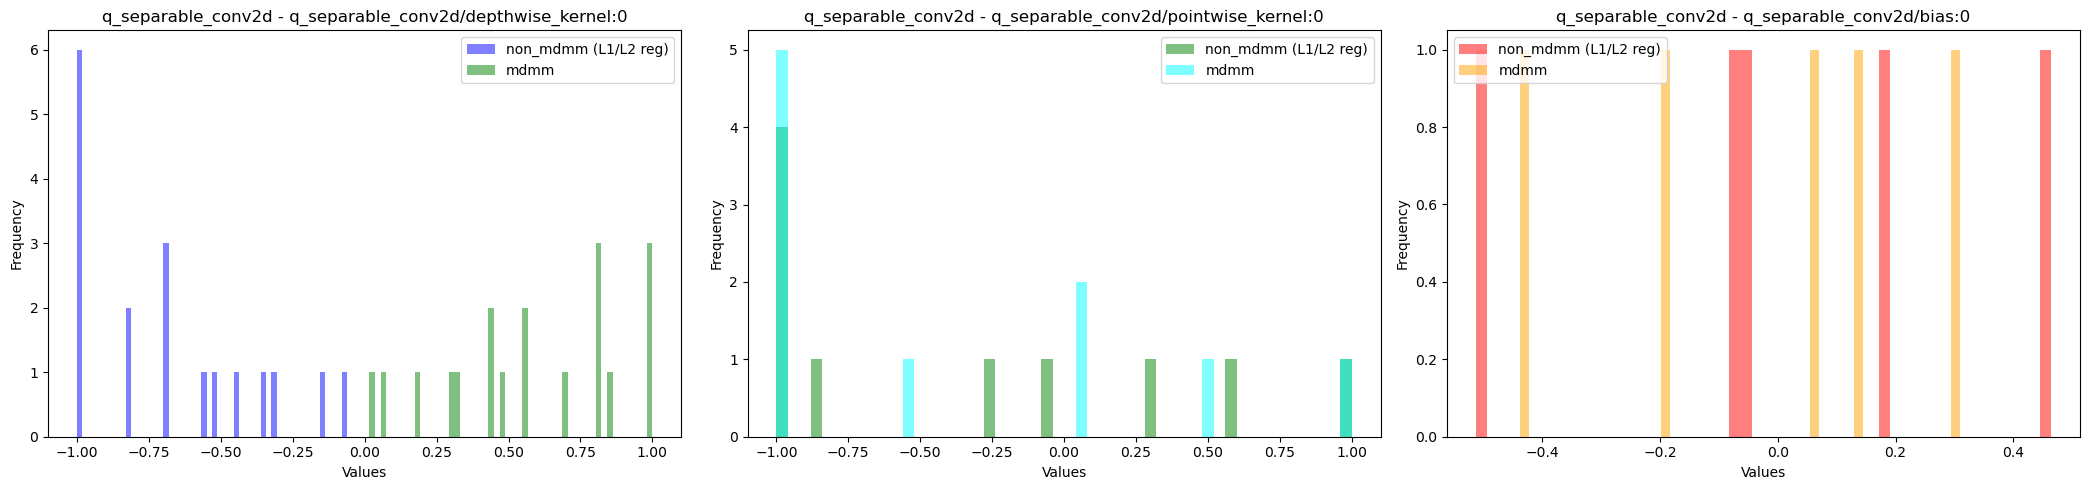

Weights and Biases Comparison for q_conv2d (Model 0) and q_conv2d_1 (Model 1):
  q_conv2d/kernel:0 - Model 0: Mean=-0.24, StdDev=0.72, Norm=0.68
  q_conv2d/kernel:0 - Model 1: Mean=-0.00, StdDev=0.57, Norm=0.37
  q_conv2d/bias:0 - Model 0: Mean=-0.07, StdDev=0.33, Norm=0.22
  q_conv2d/bias:0 - Model 1: Mean=-0.01, StdDev=0.11, Norm=0.10


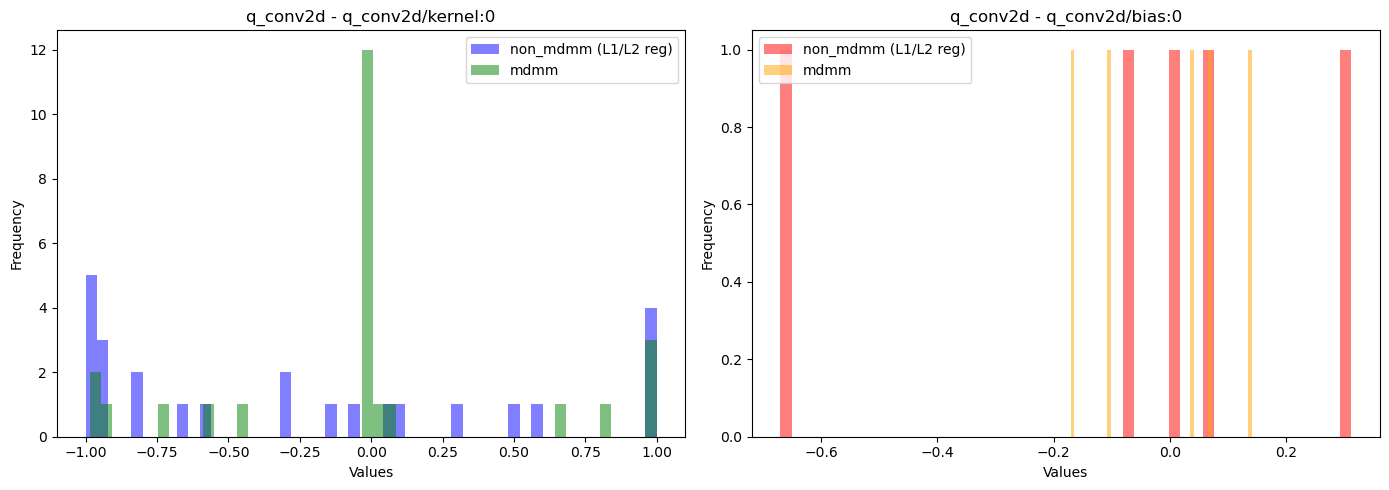

Weights and Biases Comparison for q_dense (Model 0) and q_dense_3 (Model 1):
  q_dense/kernel:0 - Model 0: Mean=-0.01, StdDev=0.23, Norm=0.17
  q_dense/kernel:0 - Model 1: Mean=0.00, StdDev=0.06, Norm=0.02
  q_dense/bias:0 - Model 0: Mean=-0.02, StdDev=0.34, Norm=0.28
  q_dense/bias:0 - Model 1: Mean=-0.04, StdDev=0.14, Norm=0.11


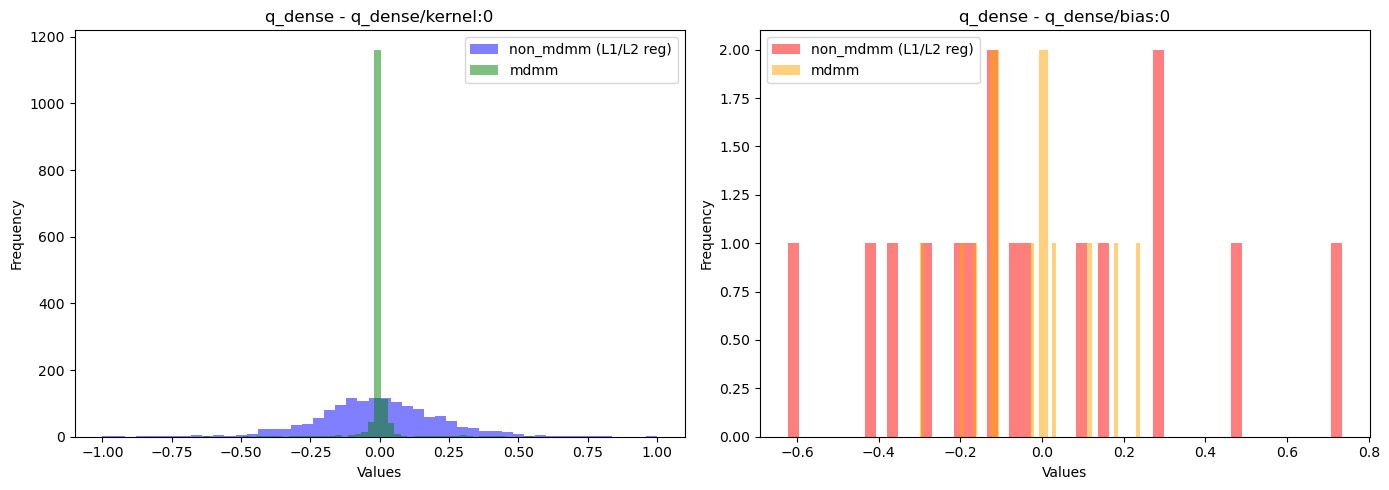

Weights and Biases Comparison for q_dense_1 (Model 0) and q_dense_4 (Model 1):
  q_dense_1/kernel:0 - Model 0: Mean=-0.00, StdDev=0.29, Norm=0.22
  q_dense_1/kernel:0 - Model 1: Mean=0.01, StdDev=0.19, Norm=0.04
  q_dense_1/bias:0 - Model 0: Mean=-0.08, StdDev=0.27, Norm=0.21
  q_dense_1/bias:0 - Model 1: Mean=0.05, StdDev=0.15, Norm=0.10


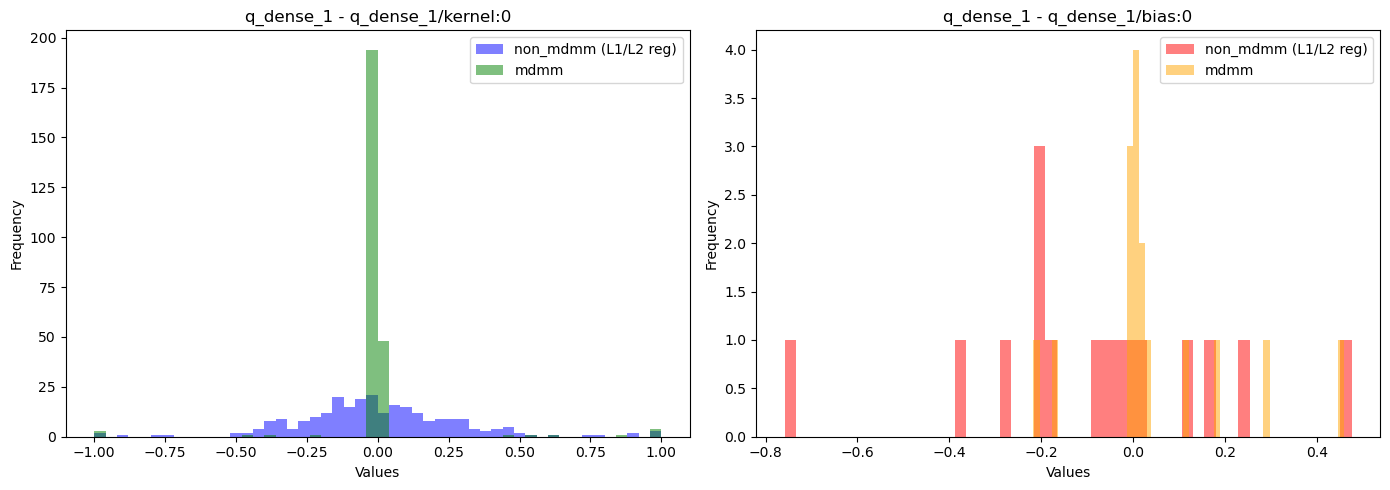

Weights and Biases Comparison for q_dense_2 (Model 0) and q_dense_5 (Model 1):
  q_dense_2/kernel:0 - Model 0: Mean=-0.00, StdDev=0.14, Norm=0.08
  q_dense_2/kernel:0 - Model 1: Mean=0.01, StdDev=0.16, Norm=0.04
  q_dense_2/bias:0 - Model 0: Mean=0.01, StdDev=0.19, Norm=0.11
  q_dense_2/bias:0 - Model 1: Mean=0.02, StdDev=0.14, Norm=0.10


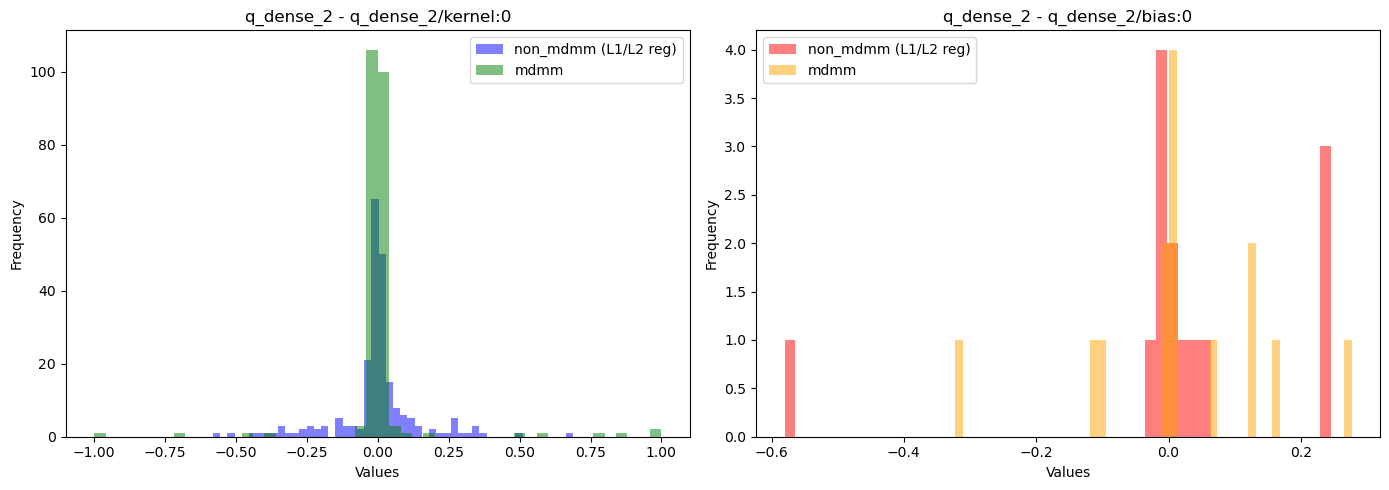

In [37]:
colors = ['blue', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

for layer1, layer2 in zip(models[0].layers, models[1].layers):
    # Check if the layer types match and if they are weight-bearing layers
    if (isinstance(layer1, (tf.keras.layers.SeparableConv2D, tf.keras.layers.Conv2D, tf.keras.layers.Dense)) and
        isinstance(layer2, (tf.keras.layers.SeparableConv2D, tf.keras.layers.Conv2D, tf.keras.layers.Dense))):

        weights_and_biases_1 = layer1.get_weights()
        weights_and_biases_2 = layer2.get_weights()

        num_tensors = min(len(weights_and_biases_1), len(weights_and_biases_2))
        
        tensor_names = [weight.name for weight in layer1.weights]
        
        print(f"Weights and Biases Comparison for {layer1.name} (Model 0) and {layer2.name} (Model 1):")

        plt.figure(figsize=(7 * num_tensors, 5))  

        for i, (tensor1, tensor2, name) in enumerate(zip(weights_and_biases_1, weights_and_biases_2, tensor_names)):
            color1 = 'red' if 'bias' in name else colors[i % len(colors)]
            color2 = 'orange' if 'bias' in name else colors[(i + 1) % len(colors)]

            tensor1_norm = np.mean(np.abs(tensor1))
            tensor1_mean = np.mean(tensor1)
            tensor1_std = np.std(tensor1)

            tensor2_norm = np.mean(np.abs(tensor2))
            tensor2_mean = np.mean(tensor2)
            tensor2_std = np.std(tensor2)

            print(f"  {name} - Model 0: Mean={tensor1_mean:.2f}, StdDev={tensor1_std:.2f}, Norm={tensor1_norm:.2f}")
            print(f"  {name} - Model 1: Mean={tensor2_mean:.2f}, StdDev={tensor2_std:.2f}, Norm={tensor2_norm:.2f}")

            plt.subplot(1, num_tensors, i + 1)
            plt.hist(tensor1.flatten(), bins=50, color=color1, alpha=0.5, label='non_mdmm (L1/L2 reg)')
            plt.hist(tensor2.flatten(), bins=50, color=color2, alpha=0.5, label='mdmm')
            plt.title(f'{layer1.name} - {name}')
            plt.xlabel('Values')
            plt.ylabel('Frequency')
            plt.legend()

        plt.tight_layout()
        plt.show()
